In [1]:
import torch
from spender.data import desi
from spender import hub
import numpy as np
import pandas as pd

import os
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'font.sans-serif': 'DejaVu Sans'})
matplotlib.rcParams.update({'font.family': 'sans-serif'})

matplotlib.rcParams['figure.dpi'] = 360
matplotlib.rcParams['text.usetex'] = True
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']

In [2]:
from astropy.io import fits
from astropy.table import Table
from desitarget.targets import desi_mask

### Get galaxies to train

#### Main

In [ ]:
table = Table.read('./desi_data/main/10001/coadd-main-dark-10001.fits')
df = table.to_pandas()

In [ ]:
for t in df['DESI_TARGET'].unique():
    print(desi_mask.names(t))

#### SV3

In [ ]:
table = Table.read('./desi_data/sv3/10158/coadd-sv3-dark-10158.fits')
df = table.to_pandas()

In [ ]:
df.shape

In [ ]:

for t in df['SV3_DESI_TARGET'].unique():
    print(desi_mask.names(t))

### Reconstruct ONE spectra

In [ ]:
inst = desi.DESI()

In [ ]:
batch_size = 32
ids = [("sv3", "dark", 10158, 'BGS')] #! only using ONE HEALPIX ID!!
                                      #same as >> /public/edr/spectro/redux/fuji/healpix/sv3/dark/101/10158/

Download data and save in batches

In [ ]:
    #* download coadd, redrock, and spectra for the given healpix id
# spectra = inst.get_spectra(dir='./desi_data/sv1/', survey='sv1', prog='dark', hpix=4679)

In [ ]:
    #* saves the spectra in batches
inst.save_in_batches("./desi_data/sv3/", ids, tag="variable", batch_size=batch_size)

Load data

In [ ]:
    #! load data from desi and not from sdss!!!
    #? check later the return value of the function to fit desi model
desi_loader = inst.get_data_loader('./desi_data/sv3/',  tag="variable", which="test", batch_size=batch_size, shuffle=False)

In [ ]:
    #! only ONE trained model -> bgs and mws from edr
desi_instrument, model = hub.load("desi_edr_galaxy", map_location=torch.device('cpu'))

In [ ]:
for batch in desi_loader:
    spec, w, z, target_id, norm, zerr = batch

    with torch.no_grad():
        spec_reconstructed = model(spec, instrument=desi_instrument, z=z)

Plot spectra

In [ ]:
def plot_spec(spec, w, wave, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4.5))
    else:
        fig = ax.get_figure()

    # plot the spectrum
    # masked areas in light color -> plot in segments of masked/unmasked spectrum
    change = (w[1:] > 0) != (w[:-1] > 0)
    start = 0
    label_set = False
    for point in list(change.nonzero().squeeze(0)) + [len(model.wave_obs)-1,]:
        color = "#ccc" if w[point] == 0 else "k"
        if not label_set and w[point] > 0:
            label_, label_set = "Data", True
        else:
            label_ = None
        ax.plot(wave[start:point], spec[start:point].detach(), c=color, label=label_, zorder=1)
        start = point

    if label is not None:
        ax.text(0.05, 0.95, label, ha='left', va='top', transform=ax.transAxes)

    ax.set_xlabel('Wavelength [Å]')
    ax.set_ylabel('Normalized Flux')
    ax.set_xlim(wave[0], wave[-1])
    ylim = [0, 1.1 * torch.max((w > 0)*spec).item()]
    ax.set_ylim(*ylim)

    return fig, ax

In [ ]:
def plot_spec_model(model, spec, w, z, id, restframe=False):

    with torch.no_grad():
        _, spec_rest, spec_reco, _ = model._forward(spec.unsqueeze(0), z=z.unsqueeze(0))
        # loss = model._loss(spec.unsqueeze(0), w, spec_reco, individual=True)
        spec_rest = spec_rest.squeeze(0).detach().cpu()
        spec_reco = spec_reco.squeeze(0).detach().cpu()

    fig, axes = plt.subplots(2, 1,
                             gridspec_kw={'height_ratios': (3,1), 'hspace': 0, 'wspace':0 }, 
                             figsize=(10,6))

    # rest or observed frame
    if not restframe:
        spec_model = spec_reco
        wave = wave_model = model.wave_obs.cpu()
        frame = "Observed"
    else:
        spec_model = spec_rest
        wave = (model.wave_obs / (1 + z)).cpu()
        wave_model = model.wave_rest.cpu()
        frame = "Restframe"

    # add ID
    plate, mjd, fiberid = id
    label = f'ID {plate}-{mjd}-{fiberid}\n $z={z:2f}$'
    plot_spec(spec.cpu(), w.cpu(), wave.cpu(), label=label, ax=axes[0]);

    # add model
    axes[0].plot(wave_model.cpu(), spec_model.cpu(), c='tab:red', label='Reconstruction', zorder=10)
    axes[0].get_xaxis().set_visible(False)
    axes[0].legend(loc='upper right', frameon=False)
    axes[0].set_xlim(wave[0], wave[-1])

    # residuals
    axes[1].plot(wave.cpu(), (spec.cpu() - spec_reco) * w.sqrt().cpu(), c='k', drawstyle='steps-mid')
    axes[1].set_ylabel(r'Residuals [$\sigma$]')
    axes[1].set_xlabel(f'{frame} Wavelength [Å]')
    axes[1].set_xlim(wave[0], wave[-1])

In [ ]:
ID = ("sv3", "dark", 10158)

for idx in range(spec_reconstructed.shape[0]):
    plot_spec_model(model, spec[idx], w[idx], z[idx], ID)
    plt.savefig(f'./plots/spectra_rec/sv3/dark/10158/spec_{idx}.png', dpi=360)
    plt.close()

 -------

In [ ]:
from spender.data.emission_lines import *
from operator import itemgetter
from itertools import groupby

In [ ]:
def find_edges(y):
    ranges = []
    for k,g in groupby(enumerate(y),lambda x:x[0]-x[1]):
        group = (map(itemgetter(1),g))
        group = list(map(int,group))
        if len(group) > 1:
            ranges.append((group[0], group[-1]))
        else:
            ranges.append((group[0], group[0]))
    return ranges

In [ ]:
def plot_spec_zoom(model, y, z, w=None, ids=None, axes=None, color="tab:red", labels=('Data', 'Model')):

    n_test = len(y)
    inch = 5
    if axes is None:
        fig, axes = plt.subplots(n_test, 5, sharex="col", sharey="row", figsize=(inch*inch, n_test*inch))
        if n_test == 1: # make sure we have a doubly indexed set of axes
            axes = [axes,]
        reuse_fig = False
    else:
        fig = axes[0][0].get_figure()
        reuse_fig = True

    with torch.no_grad():
        _, spec_rest, spec_recon, _ = model._forward(y, z=z)

    def plot_panel(sub, wave_rest, spec, wave_model, spec_model, w=None, xlims=None, plot_spec=True, plot_lines=True, label_lines=False, labels=None):

        if labels is None:
            labels = (None, None)
        drawstyle = "steps-mid" if plot_lines else None

        ylims = [0, 1.2 * torch.max((w > 0)*spec).item()]
        if plot_spec:
            sub.plot(wave_rest, spec, drawstyle=drawstyle, c='k', label=labels[0], lw=2) 
        sub.plot(wave_model, spec_model, drawstyle=drawstyle, c=color, label=labels[1], lw=2, zorder=10) 

        # lines
        lines = {
            3727: r'[O\,\textsc{ii}]',
            4861: r'H$\beta$',
            5007: r'[O\,\textsc{iii}]',
            5895: r'Na',
            6564: r'H$\alpha$',
            6585: r'[N\,\textsc{ii}]'
        }

        if plot_lines:
            for line,label in lines.items():
                if xlims[0] < line < xlims[1]:
                    sub.axvline(line, ymax=1.05, color='#888888', lw=0.5, zorder=-1, clip_on=False)
                    if label_lines:
                        sub.text(line, 1.08 * ylims[1], label, ha='center', va='bottom', rotation=90, color='#888888')

        # weights: only show in overview panel because horizontal location is mildly off
        if w is not None:
            cmap = plt.get_cmap('BuPu')
            max_color = 0.15
            w_color = cmap(max_color)
            if plot_lines is False:
                weight_im = np.ma.masked_where(w > 0, max_color * np.ones(w.shape)).reshape(1,-1)
                sub.imshow(weight_im, aspect='auto', extent=(wave_rest.min(), wave_rest.max(), 0, ylims[1]), cmap=cmap, vmin=0, vmax=1, zorder=-2, rasterized=True)

                # show unobserved region as masked
                sub.axvspan(wave_model.min(), wave_rest.min(), color=cmap(max_color), zorder=-2)
                sub.axvspan(wave_rest.max(), wave_model.max(), color=cmap(max_color), zorder=-2)

            else:
                # show unobserved region as masked
                if xlims[0] < wave_rest.min():
                    sub.axvspan(wave_model.min(), wave_rest.min(), color=w_color, zorder=-2)
                if xlims[1] > wave_rest.max():
                    sub.axvspan(wave_rest.max(), wave_model.max(), color=w_color, zorder=-2)

                # find masked regions in w
                sel = np.arange(len(w))[w <= 1e-6]
                ranges = find_edges(sel)
                for r in ranges:
                    sub.axvspan(wave_rest[r[0]], max(wave_rest[r[1]], wave_rest[r[0]+1]), color=w_color, zorder=-2)

        if xlims is not None:
            sub.set_xlim(*xlims)
        sub.set_ylim(ymin=0, ymax=ylims[1])

    for i in range(n_test):
        wave_rest = (model.wave_obs/(1+z[i])).cpu()
        wave_model = model.decoder.wave_rest.cpu()
        spec_ = y[i].cpu()
        spec_rest_ = spec_rest[i].cpu()
        z_ = z[i].cpu()
        w_ = w[i].cpu()
        if ids is not None:
            plate,mjd,fiberid = ids[i]
            title = f'ID {plate}-{mjd}-{fiberid}\n $z={z_:2f}$'
        else:
            title = f'$z={z_:2f}$'
        spec_recon_ = spec_recon[i].cpu()
        spec_rest_ = spec_rest[i].cpu()

        label_lines = i == 0
        xlims = wave_model.min(), wave_model.max()
        plot_panel(axes[i][0], wave_rest, spec_, wave_model, spec_rest_, w=w_, xlims=xlims, plot_spec=not reuse_fig, plot_lines=False, label_lines=label_lines, labels=labels)
        axes[i][0].set_ylabel('Normalized Flux')
        if not reuse_fig:
            axes[i][0].text(0.05, 0.95, title, ha='left', va='top', transform=axes[i][0].transAxes)

        # OII
        lmbda, delta = 3727, 90
        xlims = (lmbda - delta, lmbda + delta)
        plot_panel(axes[i][1], wave_rest, spec_, wave_model, spec_rest_, w=w_, xlims=xlims, plot_spec=not reuse_fig, label_lines=label_lines, labels=labels)

        # Hbeta, OIII
        lmbda, delta = 4940, 90
        xlims = (lmbda - delta, lmbda + delta)
        plot_panel(axes[i][2], wave_rest, spec_, wave_model, spec_rest_, w=w_, xlims=xlims, plot_spec=not reuse_fig, label_lines=label_lines, labels=labels)

        # Na
        lmbda, delta = 5895, 90
        xlims = (lmbda - delta, lmbda + delta)
        plot_panel(axes[i][3], wave_rest, spec_, wave_model, spec_rest_, w=w_, xlims=xlims, plot_spec=not reuse_fig, label_lines=label_lines, labels=labels)

        # Halpha, NII
        lmbda, delta = 6564, 90
        xlims = (lmbda - delta, lmbda + delta)
        plot_panel(axes[i][4], wave_rest, spec_, wave_model, spec_rest_, w=w_, xlims=xlims, plot_spec=not reuse_fig, label_lines=label_lines, labels=labels)
        if i == 0:
            axes[i][4].legend(loc='upper right', frameon=False).set_zorder(100)


    for sub in axes[-1]:
        sub.set_xlabel(r'Restframe $\lambda$ [Å]')
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    return fig, axes

In [ ]:
idx = slice(0,5)

plot_spec_zoom(model, spec[idx], z[idx], w=w[idx], ids=None)

----

### Try FAM

In [30]:
from matplotlib.collections import LineCollection

In [21]:
from accelerate import Accelerator
accelerator = Accelerator(mixed_precision="no")

model

In [ ]:
inst = desi.DESI()
batch_size = 32 #? check if this is the right batch size
ids = [("sv3", "dark", 10158, 'BGS')]
# spectra = inst.get_spectra(dir='./desi_data/sv1/', survey='sv1', prog='dark', hpix=4679)
# inst.save_in_batches("./desi_data/sv3/", ids, tag="variable", batch_size=batch_size)

In [24]:
desi_loader = inst.get_data_loader('./desi_data/sv3/',  tag="variable", which="test", batch_size=batch_size, shuffle=False)
desi_instrument, model = hub.load("desi_edr_galaxy", map_location=torch.device('cpu'))

In [25]:
for batch in desi_loader:
    spec, w, z, target_id, norm, zerr = batch

    with torch.no_grad():
        spec_reconstructed = model(spec, instrument=desi_instrument, z=z)

In [26]:
device = accelerator.device
model = model.to(device, dtype=torch.float32)
device

device(type='mps')

In [27]:
# get dataloader batch again
batch_size = 32
dataloader = inst.get_data_loader('./desi_data/sv3/',  tag="variable", which="test", batch_size=batch_size, shuffle=False)
model, dataloader = accelerator.prepare(model, dataloader)
batch = next(iter(dataloader))
spec, w, z, ids, norm, zerr = batch

In [28]:
def grad_fam(model, spec, z, l_callback, combined=False):
    # compute attention value and weights
    with torch.no_grad():
        h, a = model.encoder._downsample(spec)
        a = model.encoder.softmax(a)

    # compute spectrum reconstruction, with gradients!
    s, spec_rest, spec_reco, _ = model._forward(spec, z=z)

    # compute specific l
    l = l_callback(model, spec_reco, spec_rest)
    l.backward()

    att = a.detach()
    att_grad = model.encoder.attention_grad.detach()
    if combined:
        return att * att_grad
    return att, att_grad

def l_halpha(model, spec_reco, spec_rest, dim=None):
    sel = (model.wave_rest > 6560) & (model.wave_rest < 6570)
    diff = spec_rest[:,sel] - 1
    if dim is None:
        return torch.sum(diff)
    else:
        diff = diff.reshape(len(spec_reco), sel.sum())
        return torch.sum(diff, dim=dim)

def grad_fam_halpha(model, spec, z, combined=False):
    return grad_fam(model, spec, z, l_halpha, combined=combined)

att, att_grad = grad_fam_halpha(model, spec, z)

In [29]:
with torch.no_grad():
    s, spec_rest, spec_reco, _ = model._forward(spec, z=z)

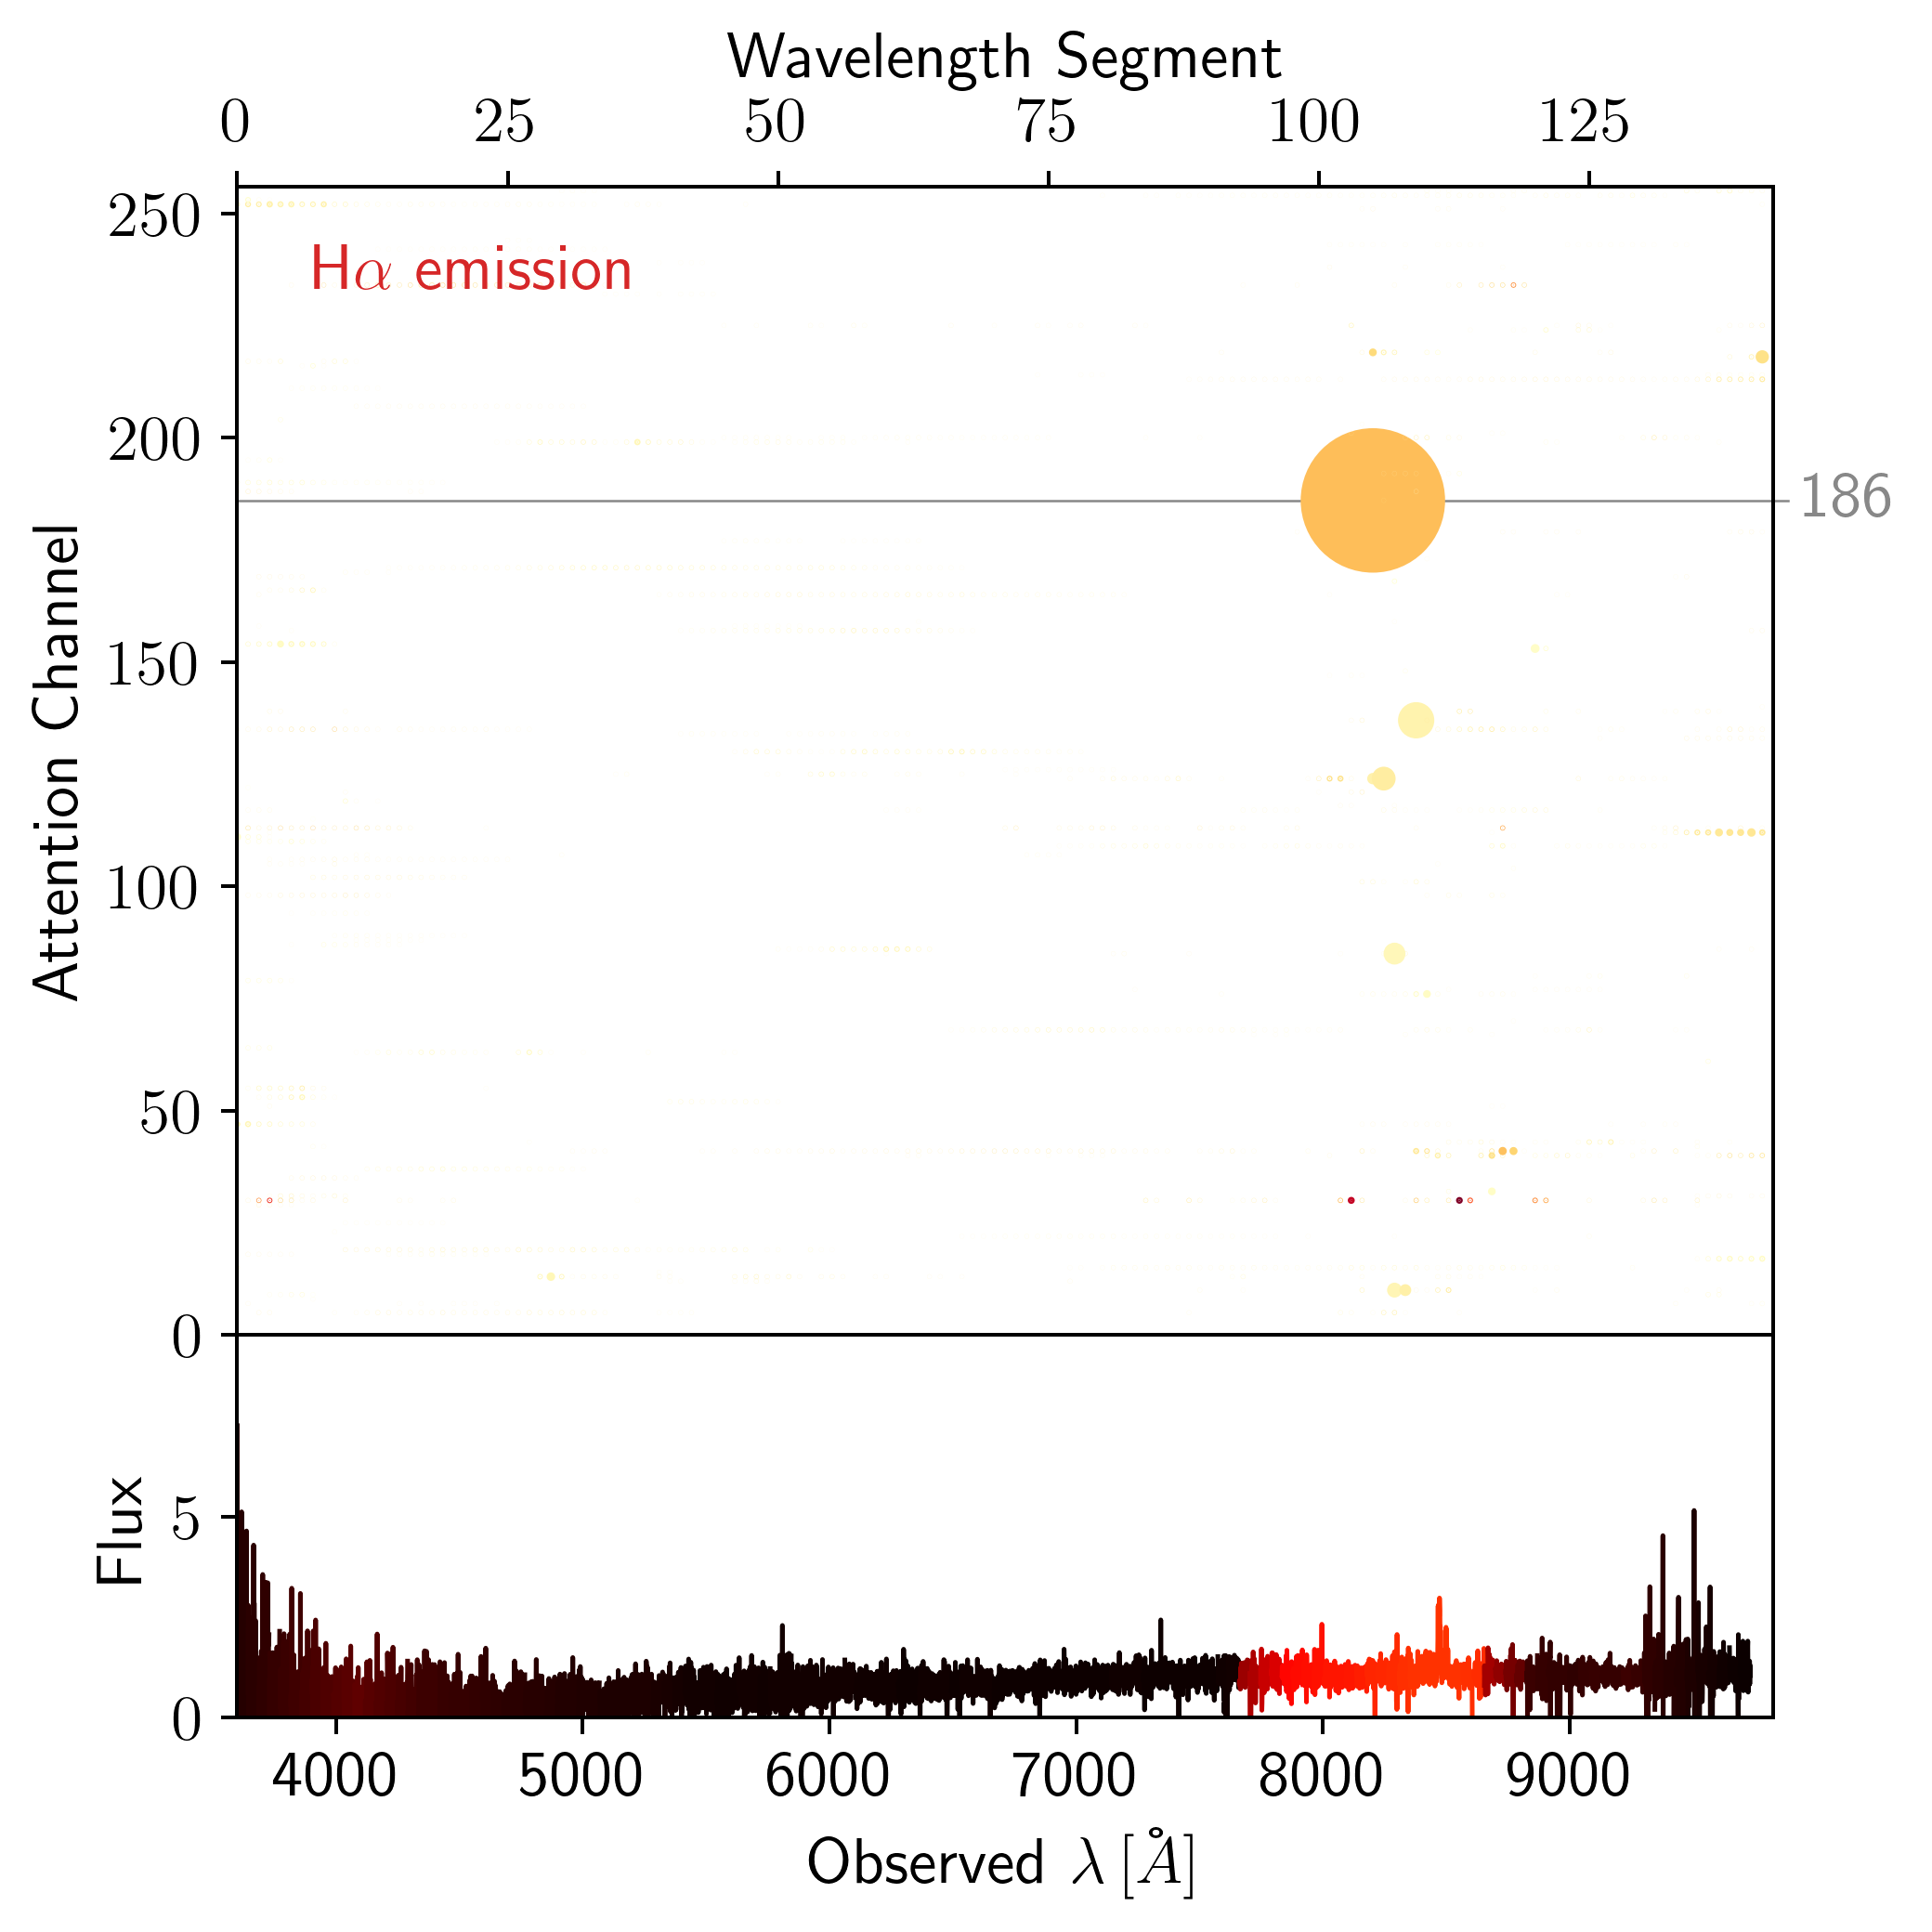

In [31]:
def att_plot(att, att_grad, spec, w, ids, wave_obs, label=None):
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': (3,1), 'hspace': 0, 'wspace':0 }, figsize=(6,6))

    att_grad_ = np.maximum(0, (att * att_grad).cpu().numpy())
    cutoff = np.percentile(att_grad_, 95)
    size = 30 * att_grad_**2
    color = att_grad.cpu()

    n_channel, n_segment = att.shape
    y, x = np.mgrid[:n_channel, :n_segment]
    sel = (att_grad_ > cutoff)
    sc = axes[0].scatter(x[sel], y[sel], s=size[sel], c=color[sel], cmap='YlOrRd', vmin=0, rasterized=True)
    axes[0].set_xlim(0,n_segment)
    axes[0].set_ylim(0,n_channel)
    axes[0].set_xlabel('Wavelength Segment')
    axes[0].set_ylabel('Attention Channel')
    axes[0].xaxis.tick_top()
    axes[0].xaxis.set_label_position('top')

    # add line and label to largest attention channel
    max_channel = np.argmax(att_grad_.max(-1))
    axes[0].axhline(max_channel, xmax=1.01, color='#888888', lw=0.5, zorder=-1, clip_on=False)
    axes[0].text(1.02, max_channel / n_channel, max_channel, c='#888', ha='left', va='center', transform=axes[0].transAxes)

    if label is not None:
        axes[0].text(0.05, 0.95, label, color='C3', ha='left', va='top', transform=axes[0].transAxes)

    #cb = fig.colorbar(sc, ax=axes[0], aspect=50)
    #cb.set_label(r'$\nabla_e l$')

    #axes[1].plot(spec, c='k', lw=0.5)
    ylims = [0, 1.3 * torch.max(spec * ( w > 0)).item()]
    axes[1].set_ylim(ylims)
    axes[1].set_xlabel(r'Observed $\lambda\,[\AA]$')
    axes[1].set_ylabel('Flux')

    # plot xaxis is in spectral elements, show observed wavelength instead
    L = len(spec)
    axes[1].set_xlim(0, L)
    new_tick_labels = np.array([ 4000, 5000, 6000, 7000, 8000, 9000 ])
    new_tick_locations = [ np.argmin(np.abs(wave_obs.cpu().numpy() - l)) for l in new_tick_labels]
    axes[1].set_xticks(new_tick_locations);
    axes[1].set_xticklabels(new_tick_labels);

    # add Grad-CAM like plot
    # sum all channels
    att_sum = att_grad_.sum(0)
    # find the approximate wavelength region for each segment
    l_s = L // n_segment # elements per segment
    l_r = 1208 # CNN receptive window
    w = int(np.floor(l_r / l_s)) + 1
    att_sum_ = np.convolve(att_sum, np.ones(w), 'same') / w
    norm = plt.Normalize(att_sum_.min(), 2*att_sum_.max())

    segments = [ np.stack((np.arange(s*l_s, (s+1)*l_s), spec[s*l_s: (s+1)*l_s].cpu().numpy()), axis=1) for s in range(n_segment) ]
    lc = LineCollection(segments, cmap='hot', norm=norm, rasterized=True)
    # Set the values used for colormapping
    lc.set_array(att_sum_)
    lc.set_linewidth(1)
    axes[1].add_collection(lc)

    #! for sdss, so not needed
    # plate,mjd,fiberid = ids
    # title = f'ID {plate}-{mjd}-{fiberid}'
    # axes[1].text(0.05, 0.9, title, ha='left', va='top', transform=axes[1].transAxes)

    fig.tight_layout()
    return fig

idx = 5 # 108
fig = att_plot(att[idx], att_grad[idx], spec[idx], w[idx], ids[idx], model.wave_obs, label=r"H$\alpha$ emission")

(3600.0, 9200.0)

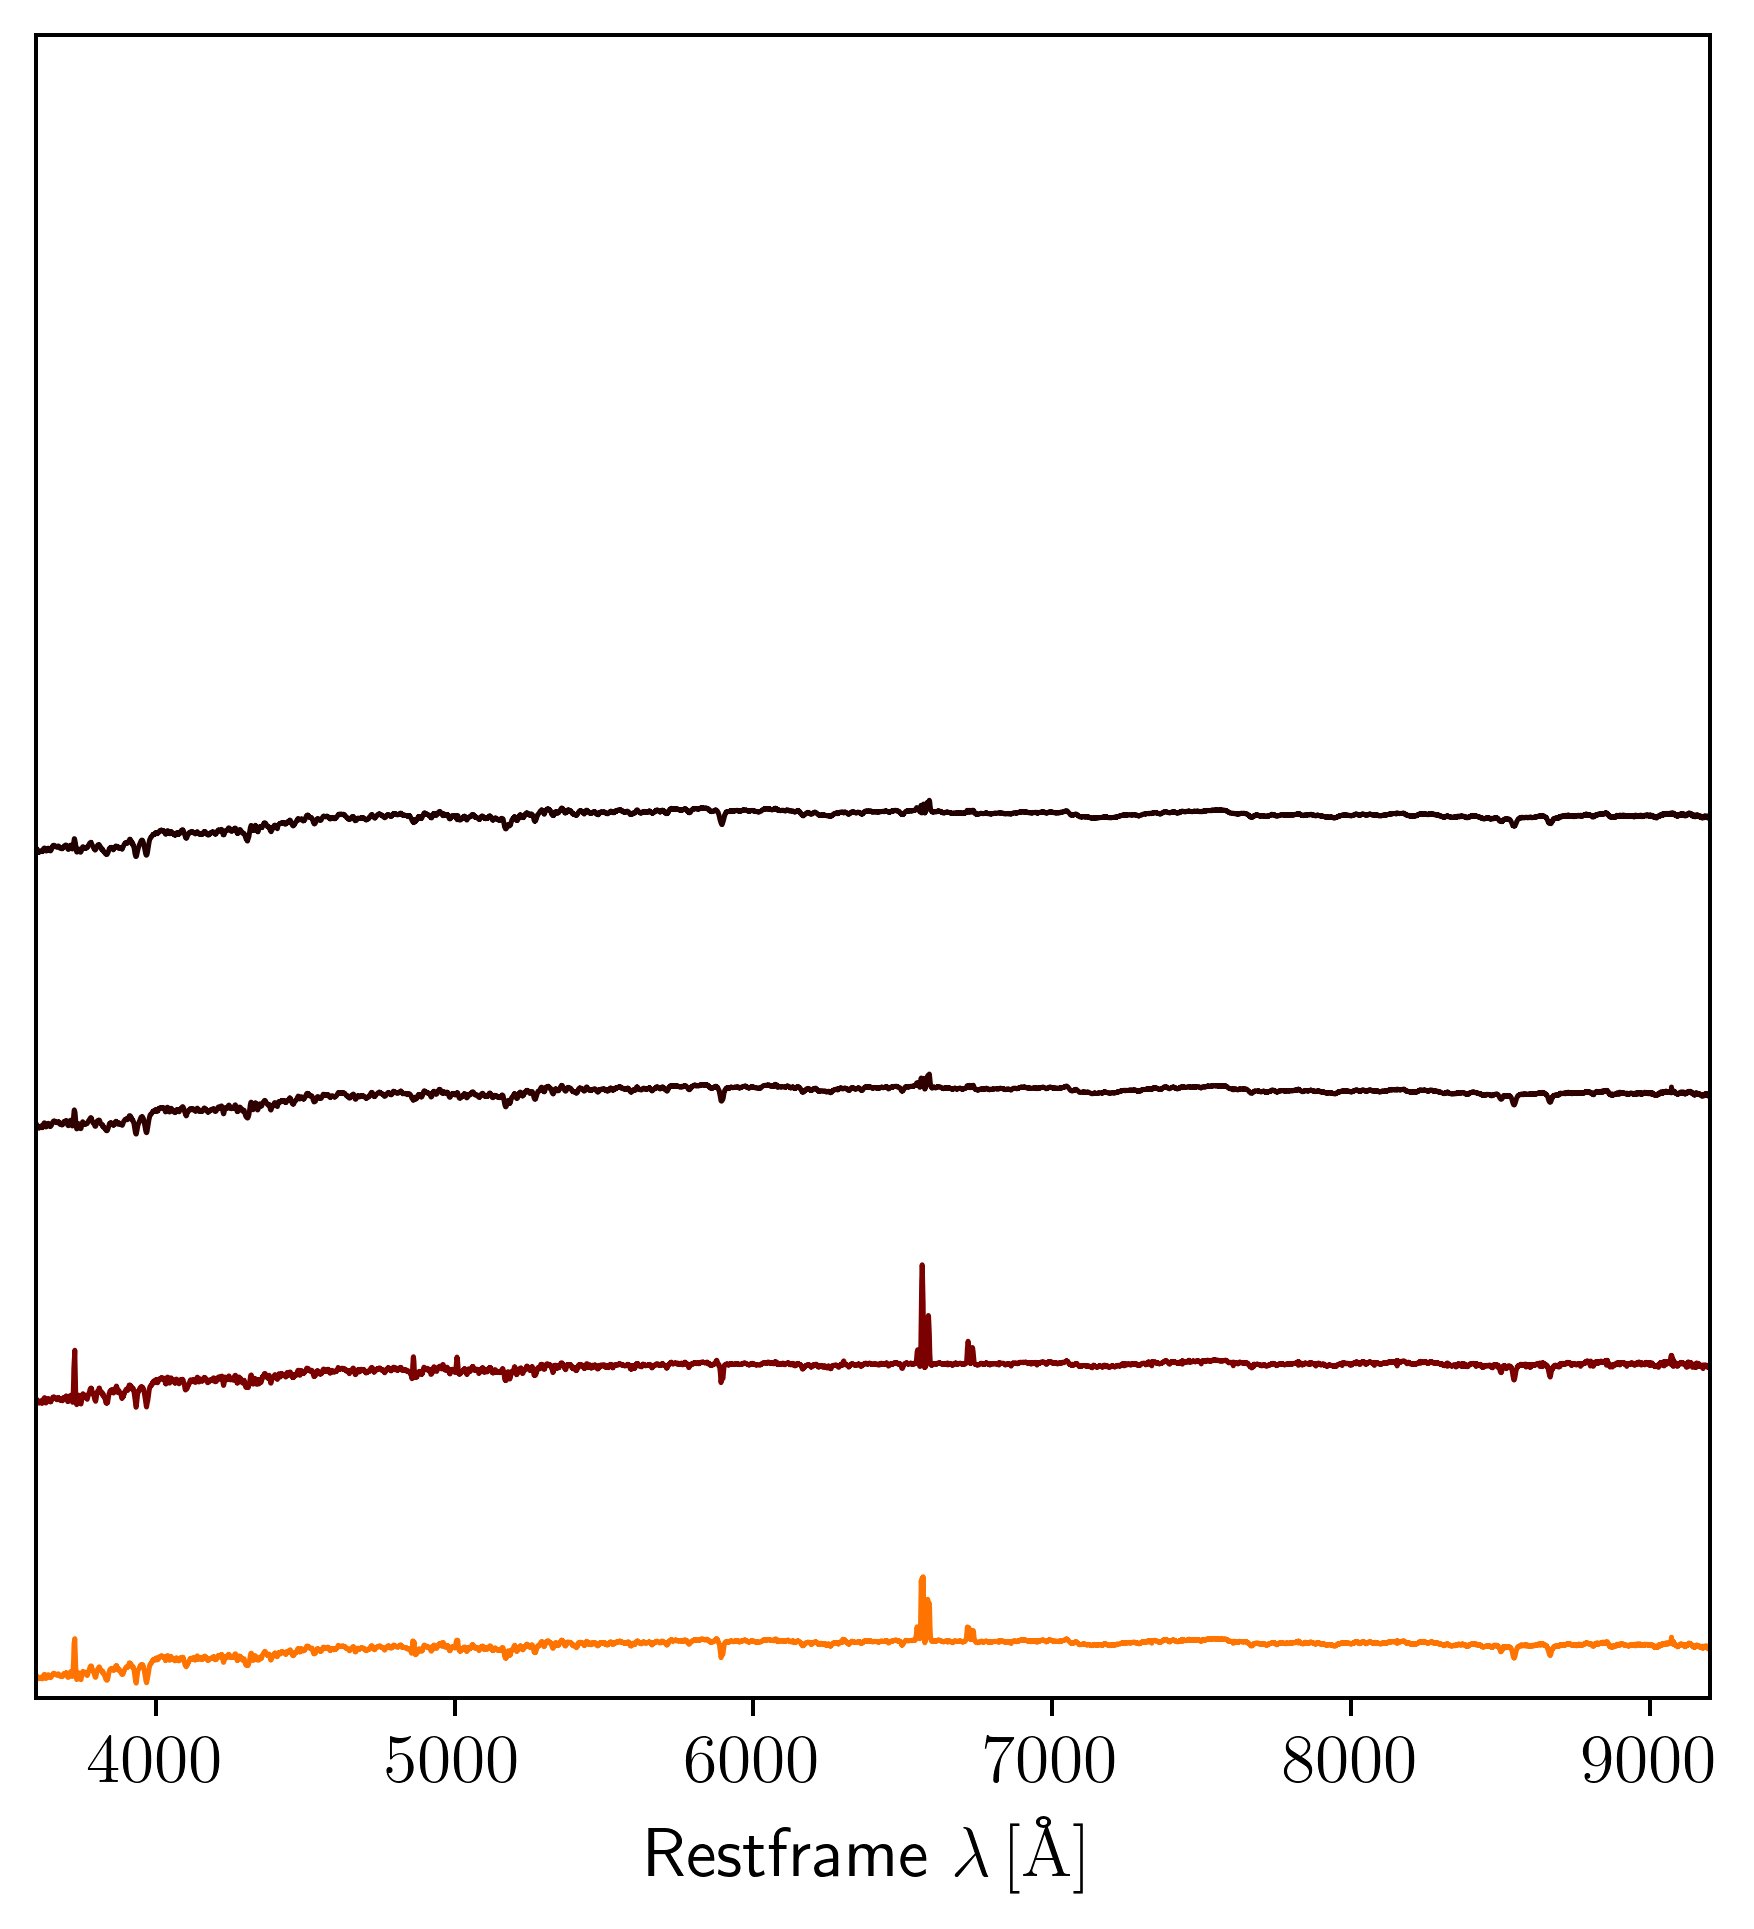

In [32]:
plt.figure(figsize=(6,6))
att_grad_ = att * att_grad
channel_ = att_grad_[:, 106, :].sum(-1)
norm = plt.Normalize(channel_.min(), 2*channel_.max())

cmap = plt.get_cmap('hot')

for i, idx in enumerate(torch.argsort(channel_, 0, descending=True)[::8][:6]):
    plt.plot(model.wave_rest.cpu(), spec_rest[idx].cpu()+5*i, c=cmap(norm(channel_[idx].cpu())), lw=1)
plt.ylim(0, 30)
plt.xlabel(r'Restframe $\lambda\,[\mathrm{\AA}]$')
plt.yticks([])
plt.xlim(3600,9200)

In [33]:
ss, losses, halphas, zs, norms, ids_list = [], [], [], [], [], []
with torch.no_grad():
    for spec, w, z, id_tensor, norm, zerr in dataloader:
        # latent space and reconstruction
        #! this is the same as in the training loop
        s = model.encode(spec)
        s, spec_rest, spec_reco, _ = model._forward(spec, z=z, s=s)

        # reconstruct loss (original doesnt work on desi)
        valid = (w > 0).float()
        loss = (0.5 * w * valid * (spec - spec_reco).pow(2)).sum(dim=1) / spec.shape[1]
        halpha = l_halpha(model, spec_reco, spec_rest, dim=-1)

        ss.append(s.cpu())
        losses.append(loss.cpu())
        halphas.append(halpha.cpu())
        zs.append(z.cpu())
        norms.append(norm.cpu())
        ids_list.append(id_tensor.cpu())

ss      = np.concatenate(ss,     axis=0)
losses  = np.concatenate(losses, axis=0)
halphas = np.concatenate(halphas,axis=0)
zs      = np.concatenate(zs,     axis=0)
norms   = np.concatenate(norms,  axis=0)
ids_arr = np.concatenate(ids_list, axis=0)

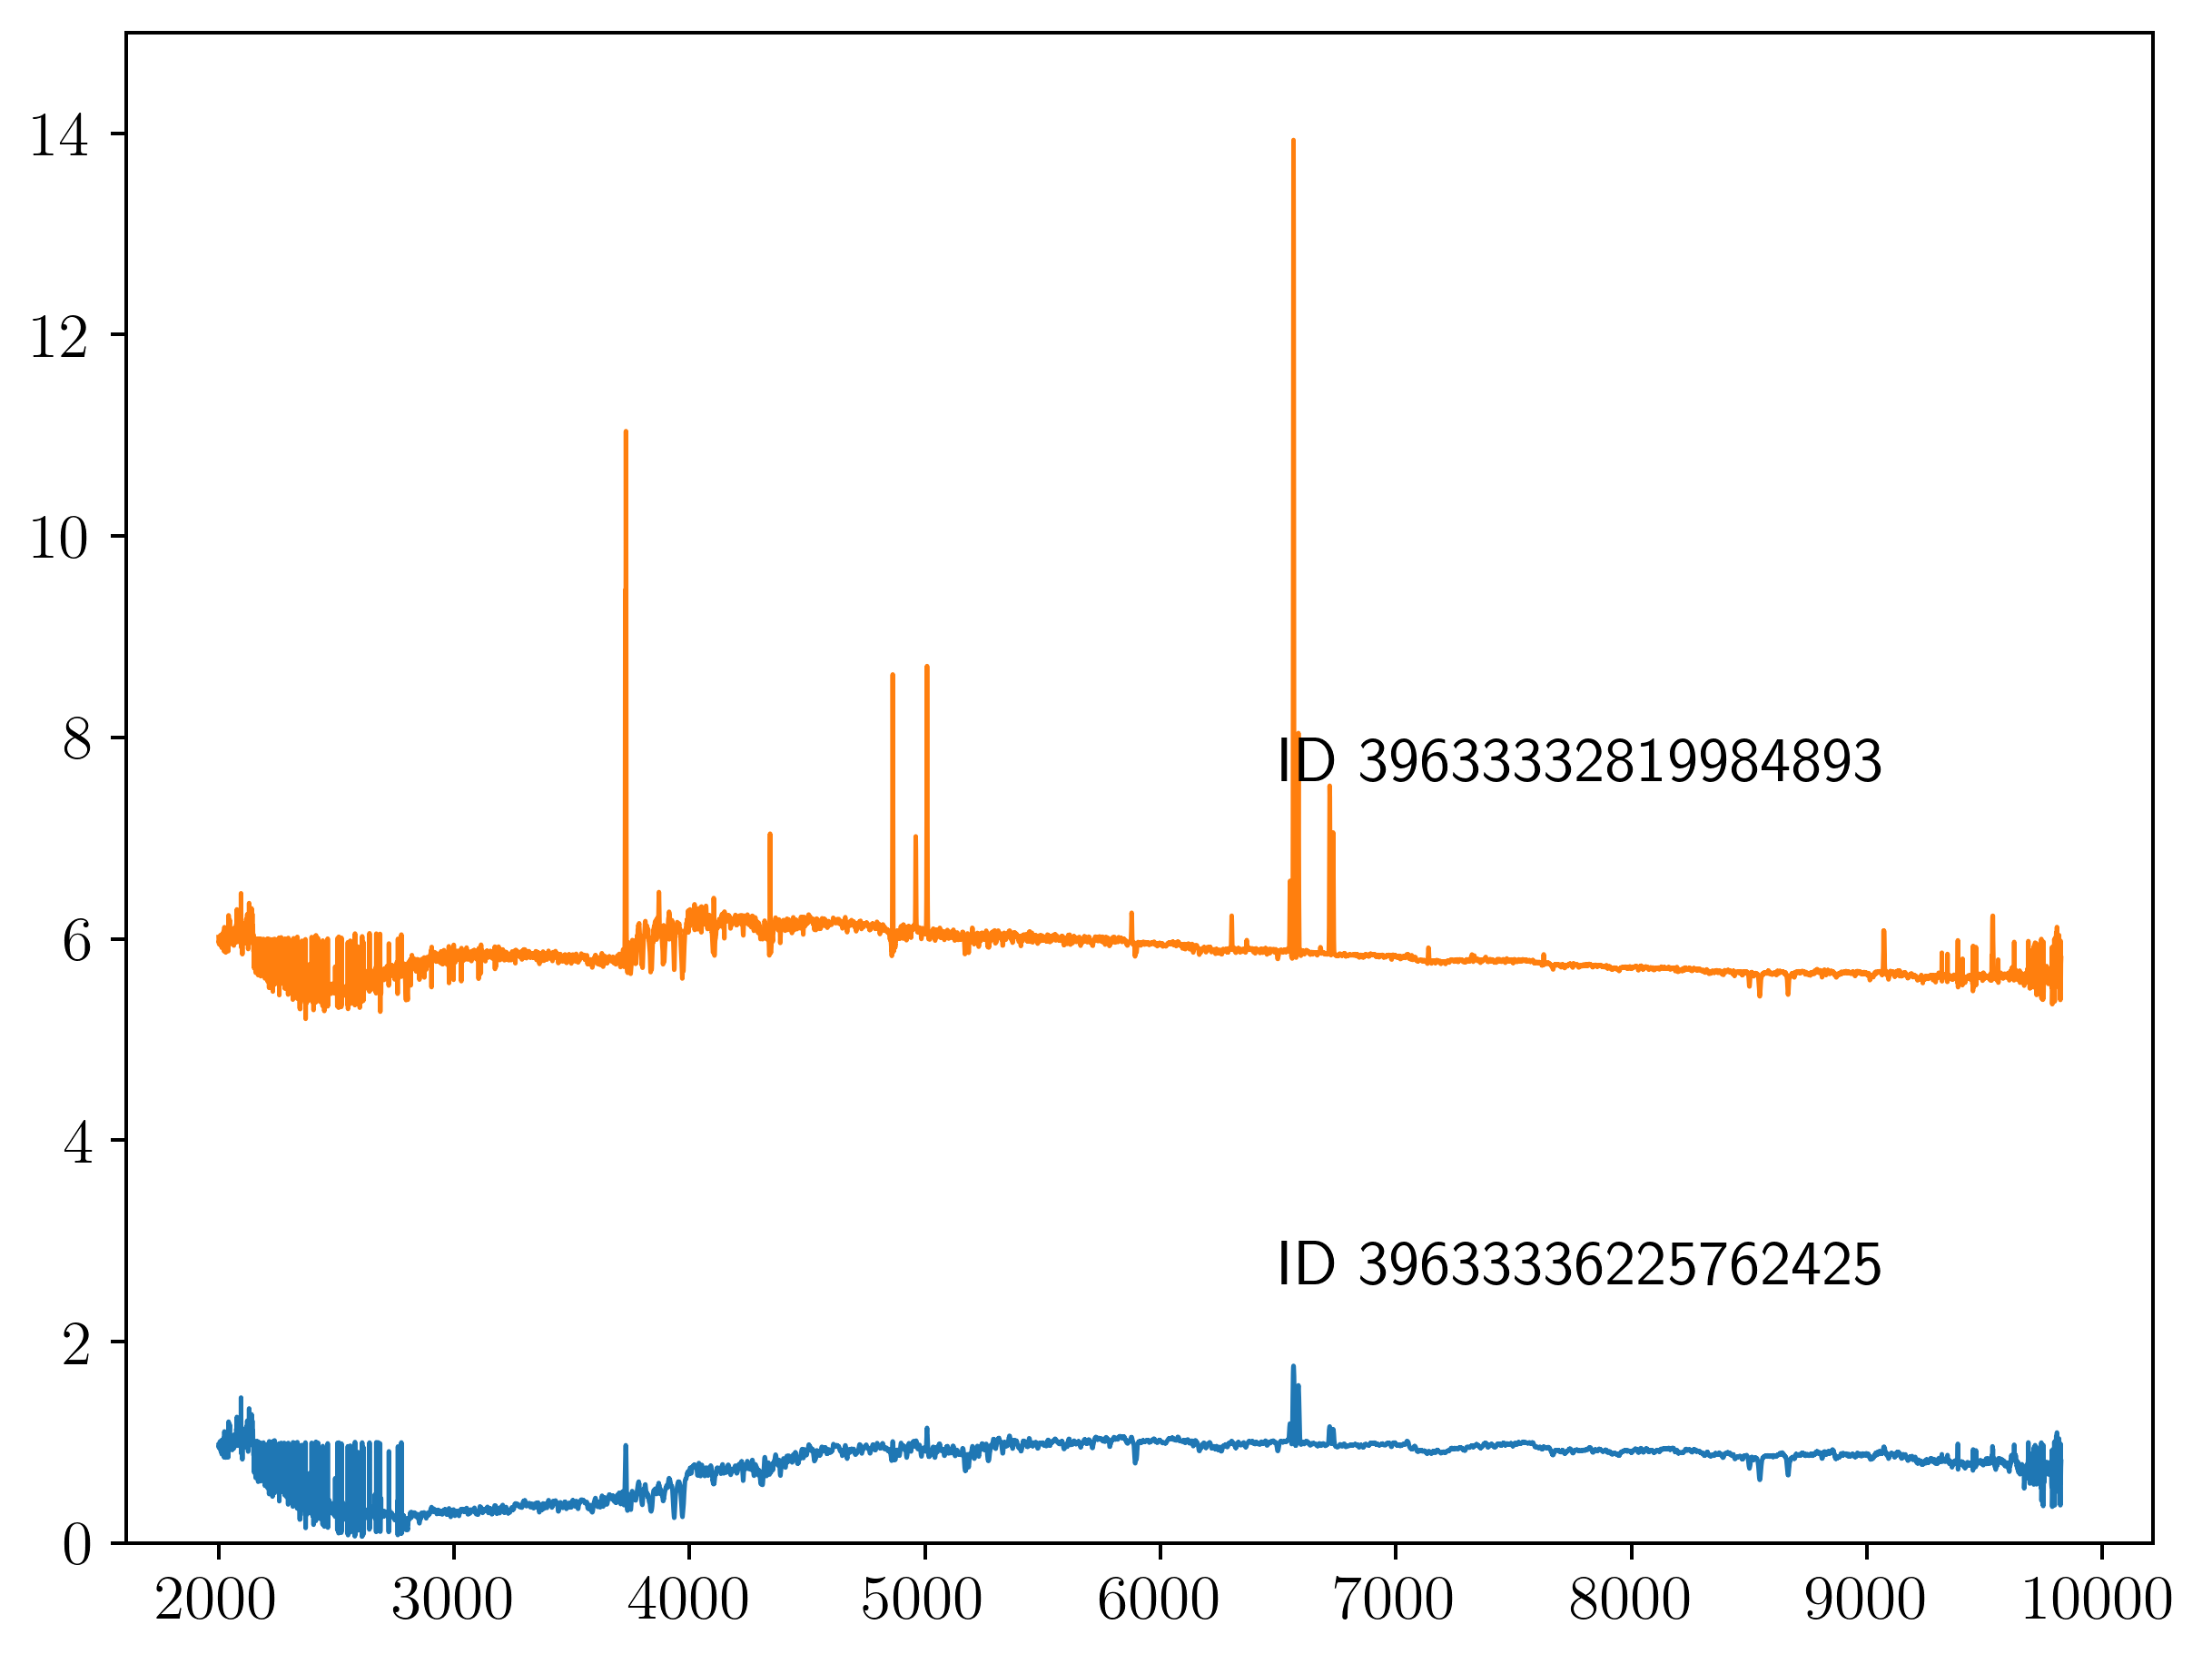

In [34]:
channel_ = losses
idxes = torch.argsort(torch.from_numpy(channel_), 0, descending=True)[::1][:2]

plt.figure(figsize=(8, 6))
for i, idx in enumerate(idxes[:]):
    plt.plot(
        model.wave_rest.cpu(),
        spec_rest[idx].cpu() + 5*i,
        lw=1
    )
    target_id = int(ids_arr[idx])
    plt.text(
        9100, 5*i+3,
        f'ID {target_id}',
        ha='right', va='top'
    )
plt.ylim(0, 5*len(idxes) + 5)
plt.show()

#### Embedding

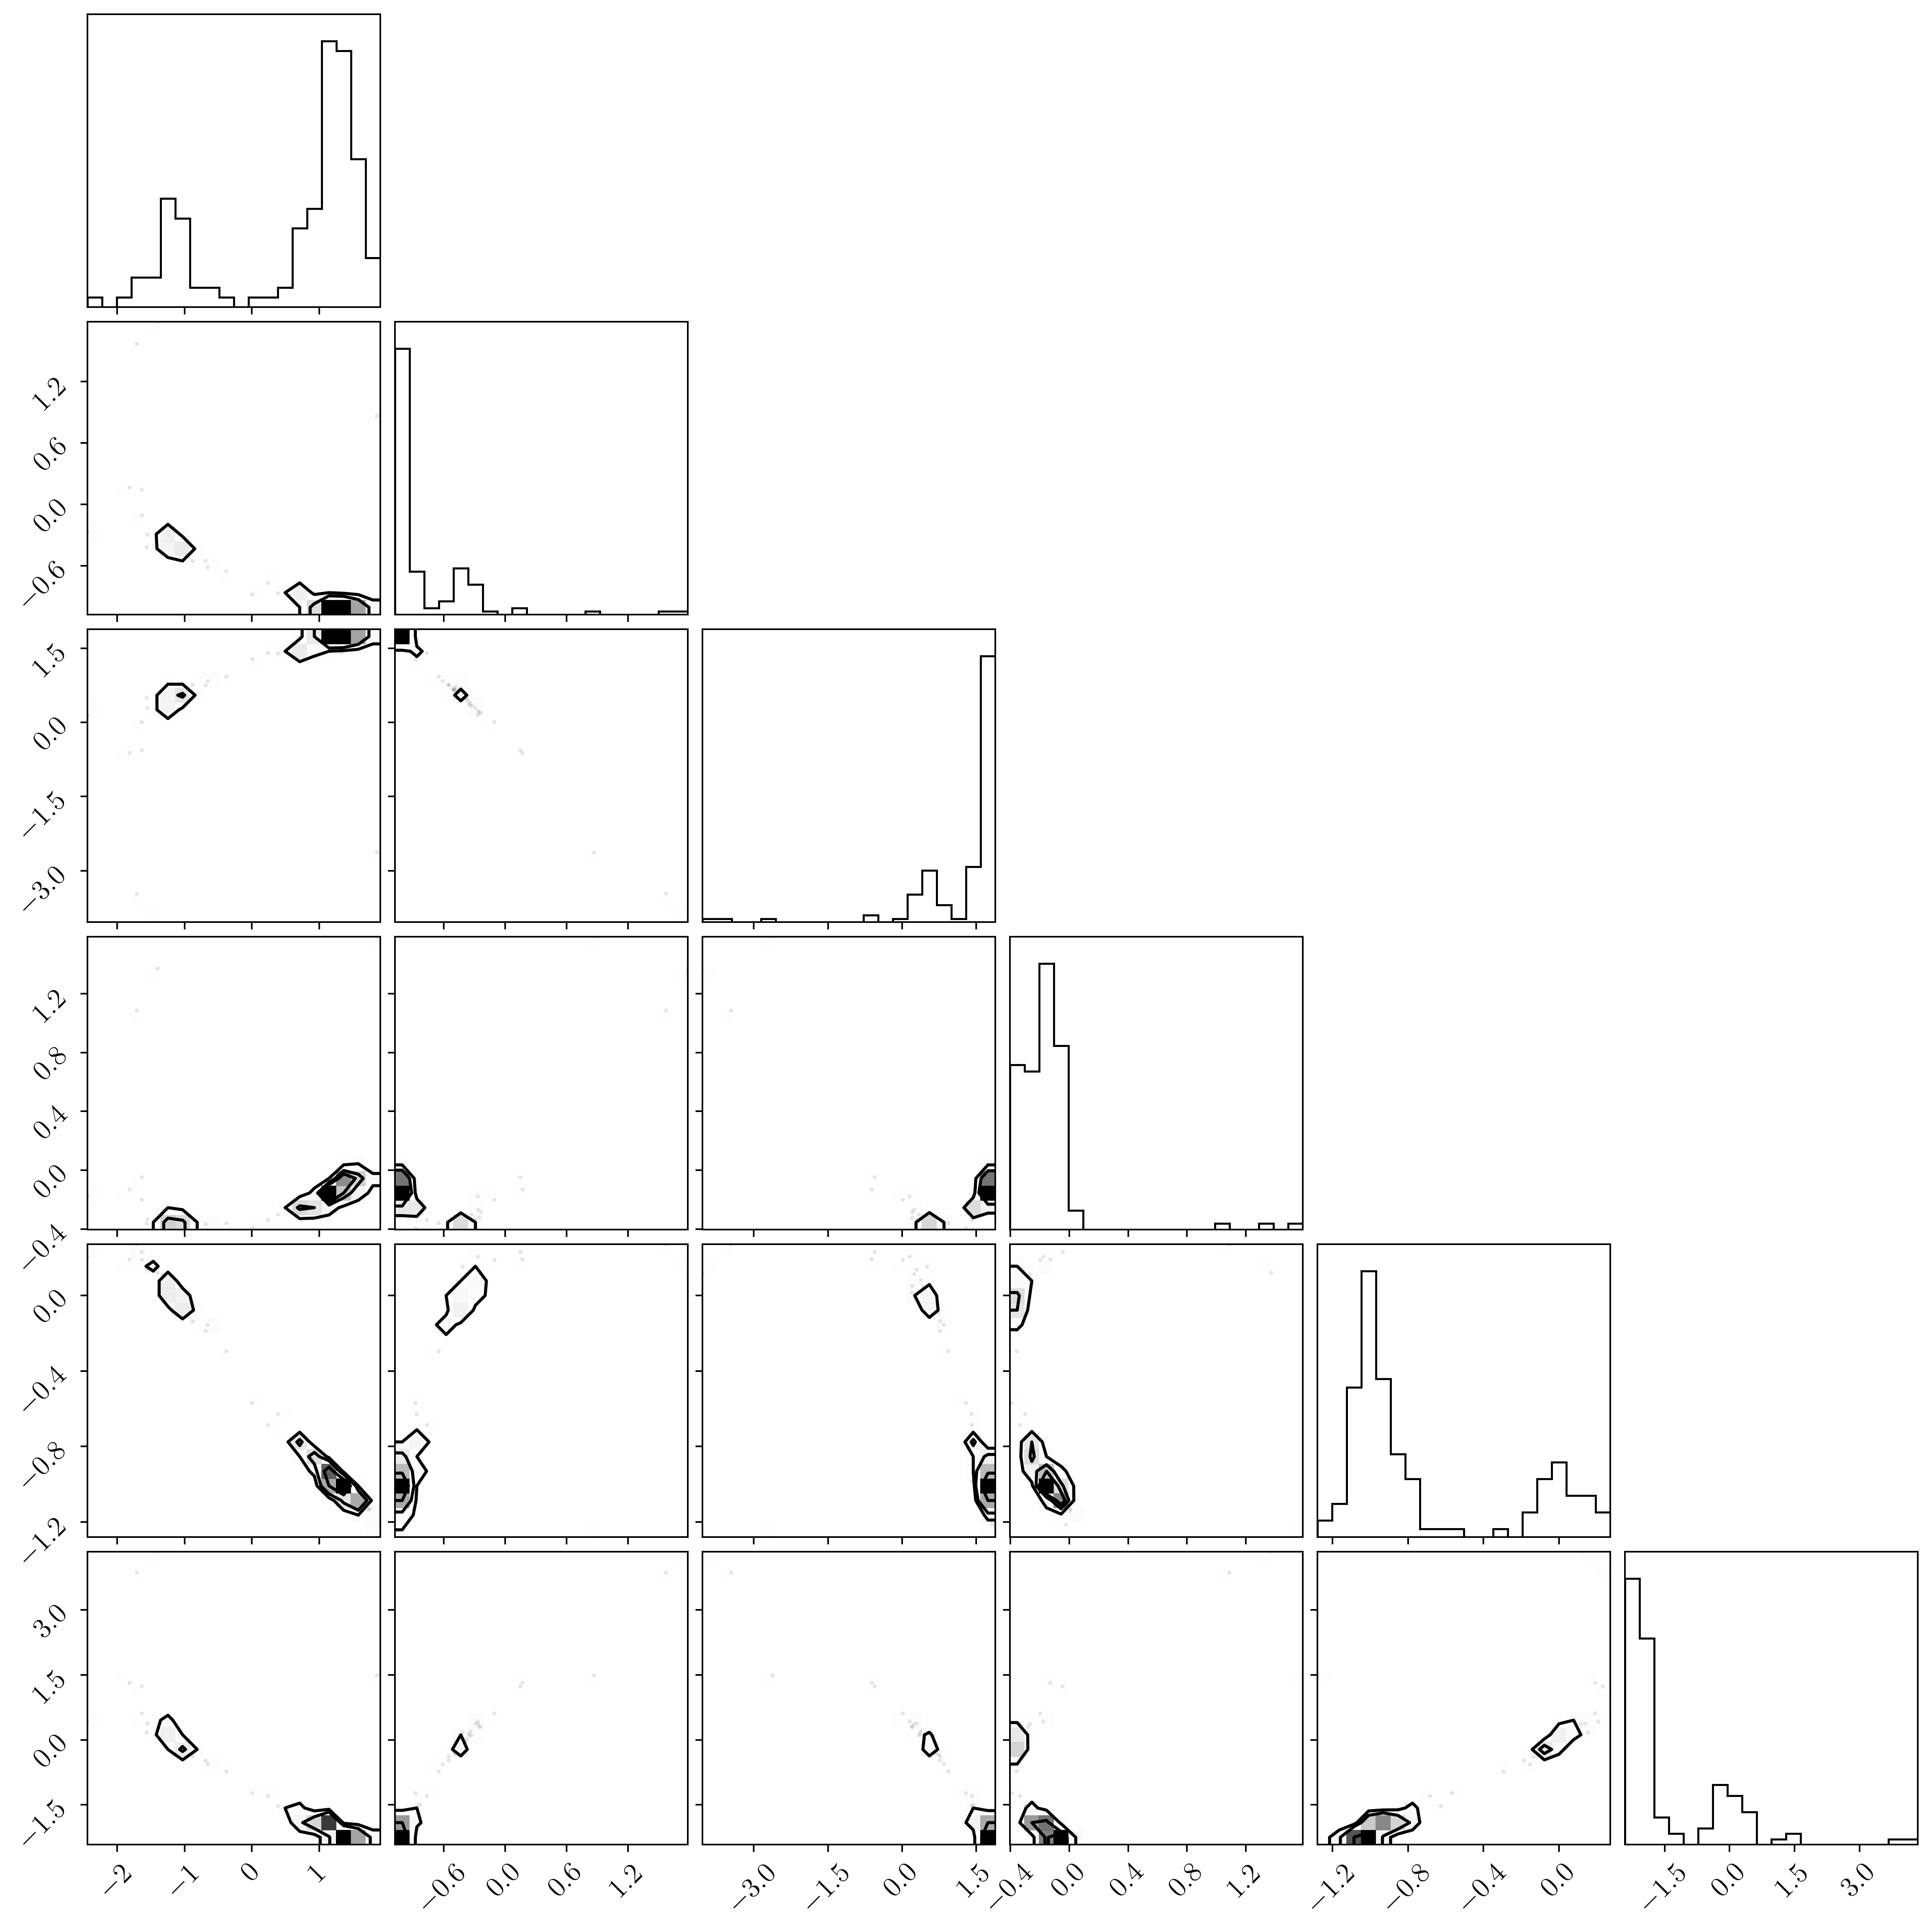

In [ ]:
import corner
fig = corner.corner(ss) #! not a lot of data but nice to have?

In [35]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(ss)

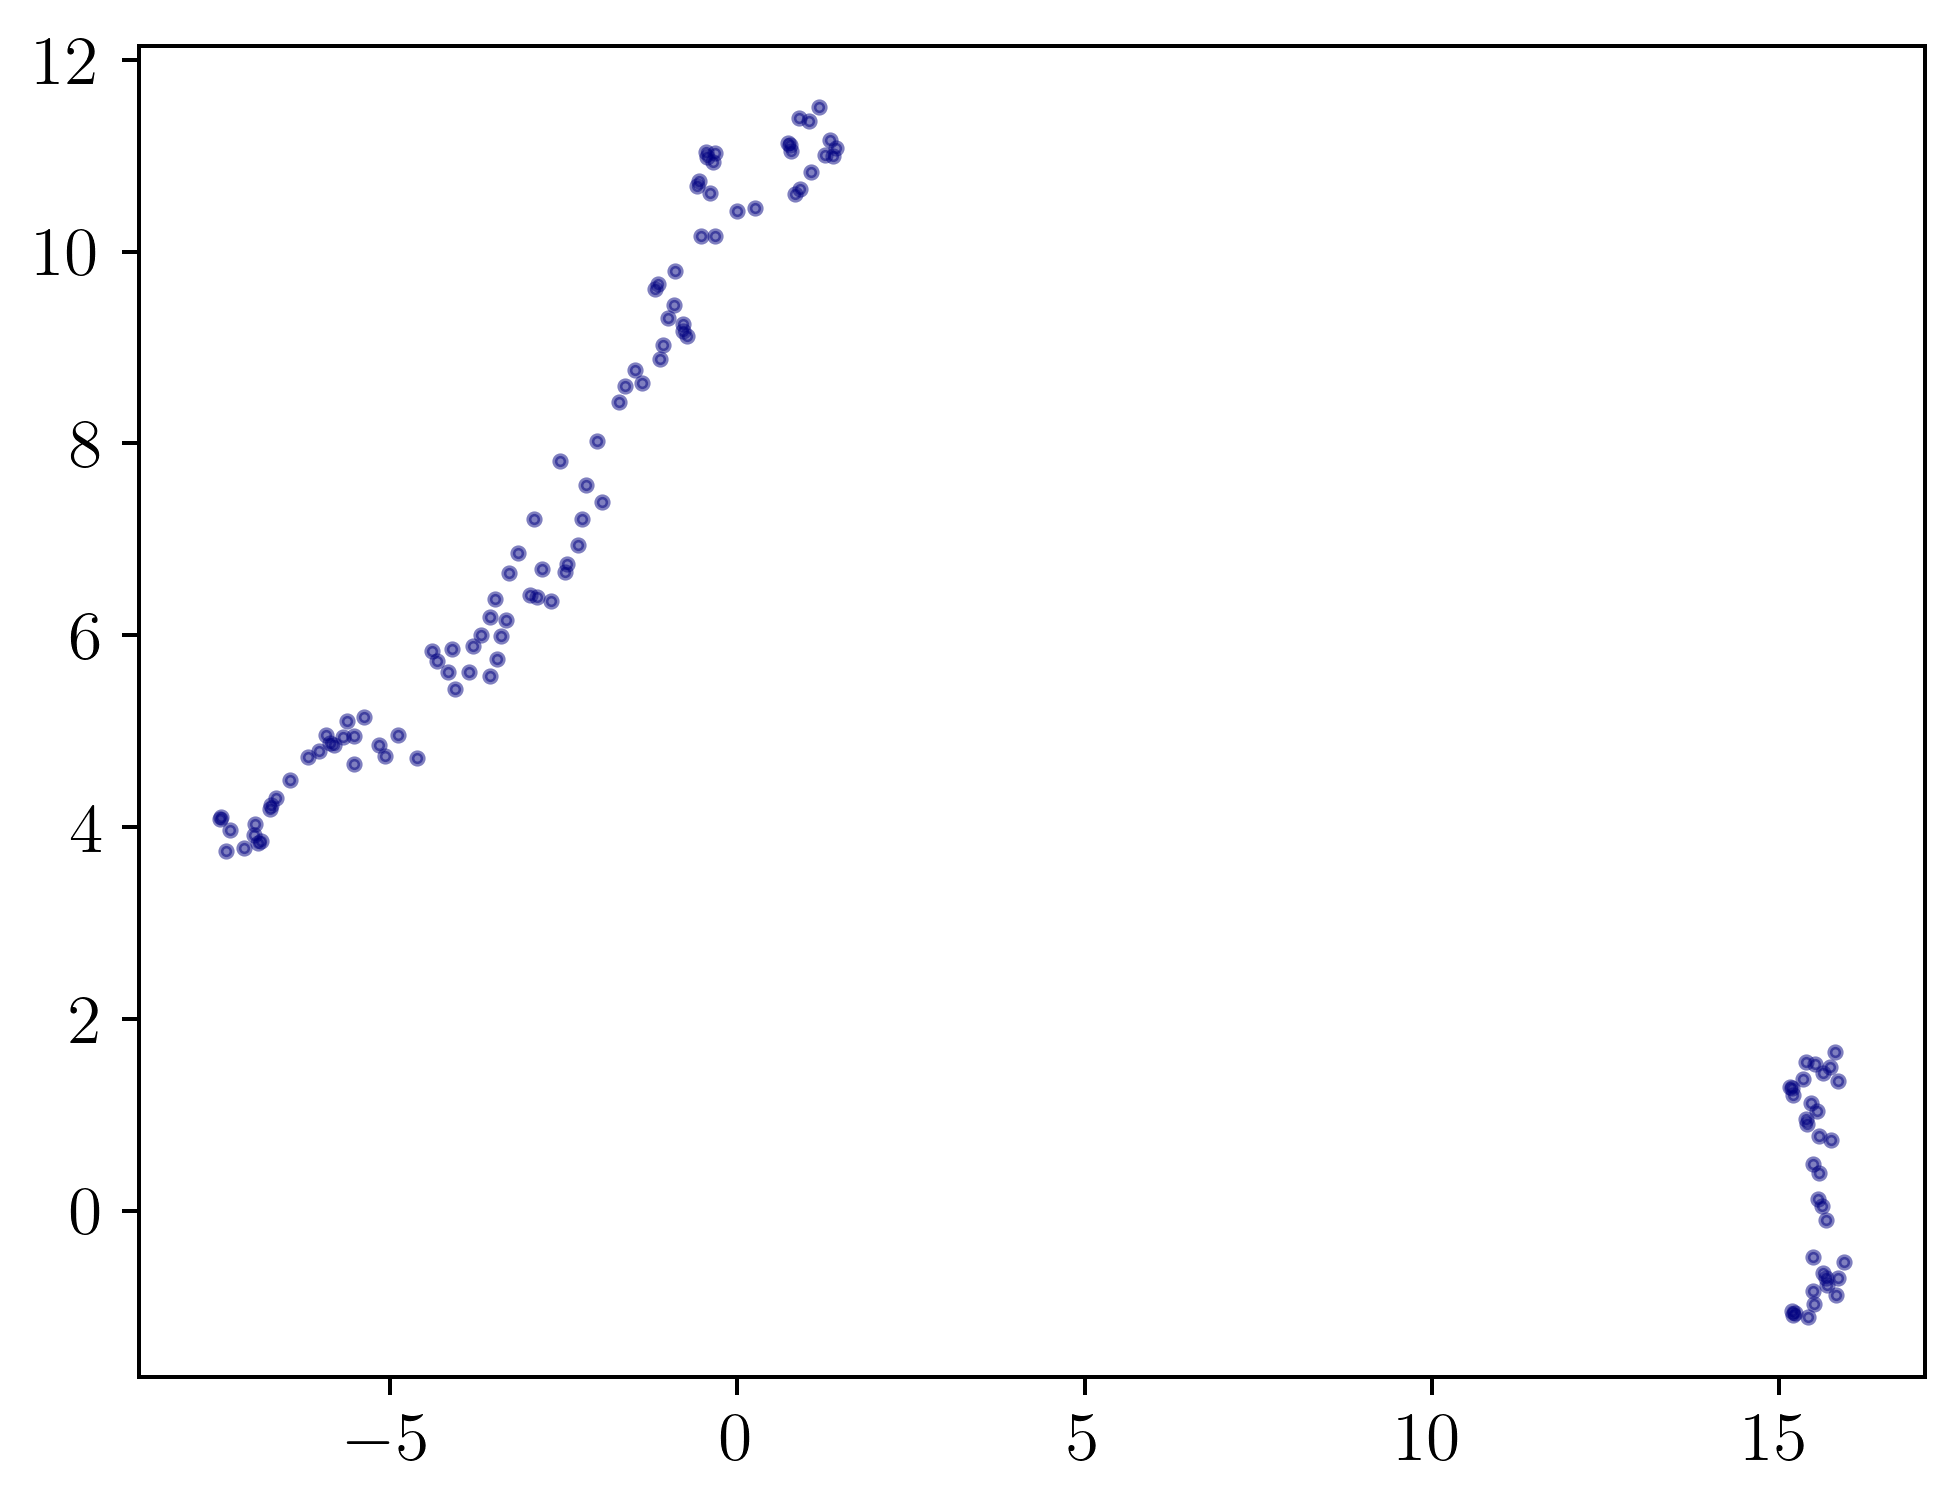

In [36]:
plt.scatter(embedding[:,0], embedding[:,1], c='navy', s=5, alpha=0.5)
plt.show()